#### Adamantios Zaras AM: 06
#### Panagiotis Souranis AM: 17

# Description

In this part of the project, we used 3 different cost-sensitive learning techniques in the Data Mining Cup Dataset, combined with 3 different learning algorithms and compared them with simple usage of the classifiers, thus not taking into consideration the classification cost.  

The techniques we used are:
- Sigmoid Probability Calibration
- Resampling, using the **Roulette Sampling** method.
- Example weighting.  

The algorithms we combined with the above techniques are:
- Random Forest
- Linear SVM
- Naive Bayes

First, we load and scale our dataset and split them to training and test pairs. Next, we define the classifiers and perform a 10 fold cross validation hyperparameters search, using the training data, while trying to minimize the CostCla librarie's cost loss. We then use the best hyperparameters found from this procedure and fit the models using the 3 different techniques mentioned above. Finally, we make predictions using the test data which were left out.  
We search for hyperparameters first, because we do not want to introduce bias to the final model.

# Global

### Package Installation

In [0]:
!pip install git+git://github.com/albahnsen/CostSensitiveClassification.git

### Imports

In [0]:
import io
import time

import requests
import numpy as np
import scipy
from pandas import read_csv
from sklearn.preprocessing import MinMaxScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from costcla.models import BayesMinimumRiskClassifier
from costcla.metrics import cost_loss
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Import utils functions for cost sensitive learning.
from utils import report, full_cs_report, cost

%matplotlib inline

### Prepare Dataset

In [0]:
# Read the dataset.
url="http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/heart/heart.dat"
s=requests.get(url).content
dataset=read_csv(io.StringIO(s.decode('utf-8')), sep=' ')

# Get x and y.
X, y = dataset.iloc[:, :-1].values, dataset.iloc[:, -1].values

# Convert labels from 1, 2 to 0, 1.
y[y == 1] = 0
y[y == 2] = 1

# Create class names.
labels = ['Absence', 'Presence']


# Define the cost matrix.
# _________  absence  presence
# absence    0        1
# presence   5        0 
fp = np.full((y.shape[0], 1), 5)
fn = np.full((y.shape[0], 1), 1)
tp = np.zeros((y.shape[0], 1))
tn = np.zeros((y.shape[0], 1))
cost_matrix = np.hstack((fp, fn, tp, tn))

# Split to training and test pairs.
X_train, X_test, y_train, y_test, cost_mat_train, cost_mat_test = \
train_test_split(X, y, cost_matrix, test_size=0.3, random_state=0)

# Scale data.
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.astype(float))
X_test = scaler.fit_transform(X_test.astype(float))

### Define classifiers

In [0]:
# Random Forest
forest = RandomForestClassifier(random_state=0, n_jobs=-1)

# Linear SVM
svm = LinearSVC(random_state=0)

# Naive Bayes
bayes = MultinomialNB()

# Hyperparameters Tuning

### Random Forest Tuning

#### Random Search
Run a Random Search using 10 fold cross validation.

In [5]:
# Specify parameters and distributions to sample from 
param_dist = {'max_depth': scipy.stats.randint(1, 30),
              'max_features': scipy.stats.randint(1, X.shape[1]),
              'min_samples_split': scipy.stats.randint(2, X.shape[0] / 2),
              'n_estimators': scipy.stats.randint(10, 600),
              'criterion': ['gini', 'entropy']}
# Specify number of random candidates to be created.
candidates = 200

# Run a random search CV.
random_search = RandomizedSearchCV(forest, param_dist, candidates, cv=10, 
                                   n_jobs=-1, verbose=5, iid=True, scoring=cost)
start = time.time()
random_search.fit(X_train, y_train)
print('RandomizedSearchCV took {:.2f} seconds for {} candidates.'
      .format((time.time() - start), candidates))
report(random_search.cv_results_)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  9.8min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed: 10.7min finished


RandomizedSearchCV took 643.92 seconds for 200 candidates.
Model with rank: 1
Mean validation score: -8.899 (std: 4.645)
Parameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 6, 'min_samples_split': 50, 'n_estimators': 237}

Model with rank: 2
Mean validation score: -8.926 (std: 5.351)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 9, 'min_samples_split': 50, 'n_estimators': 278}

Model with rank: 2
Mean validation score: -8.926 (std: 5.351)
Parameters: {'criterion': 'gini', 'max_depth': 28, 'max_features': 9, 'min_samples_split': 50, 'n_estimators': 513}



#### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [8]:
# Specify parameter_grid for the search.
param_grid = {'max_depth': range(18, 22),
              'max_features': range(4, 8),
              'min_samples_split': range(49, 51),
              'n_estimators': range(234, 242),
              'criterion': ['gini', 'entropy']}

# Run a grid search CV.
grid_search = GridSearchCV(forest, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True, scoring=cost)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 512 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   41.0s
[Parallel(n_jobs=-1)]: Done 284 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 878 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 1148 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1454 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 1796 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 2174 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 3038 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 3524 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 4046 tasks      | ela

GridSearchCV took 1358.39 seconds.
Model with rank: 1
Mean validation score: -8.899 (std: 4.645)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 6, 'min_samples_split': 49, 'n_estimators': 234}

Model with rank: 1
Mean validation score: -8.899 (std: 4.645)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 6, 'min_samples_split': 49, 'n_estimators': 235}

Model with rank: 1
Mean validation score: -8.899 (std: 4.645)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 6, 'min_samples_split': 49, 'n_estimators': 236}

Model with rank: 1
Mean validation score: -8.899 (std: 4.645)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 6, 'min_samples_split': 49, 'n_estimators': 237}

Model with rank: 1
Mean validation score: -8.899 (std: 4.645)
Parameters: {'criterion': 'gini', 'max_depth': 18, 'max_features': 6, 'min_samples_split': 49, 'n_estimators': 238}

Model with rank: 1
Mean validation score: -8.899 (std: 4.645)
Paramete

#### Use best hyperparameters.

In [0]:
forest.max_depth = 18
forest.max_features = 6
forest.min_samples_split = 49
forest.n_estimators = 234
forest.criterion = 'gini'

### SVM Tuning

#### Grid Search
Run a Grid search, using 10 fold cross validation.

In [6]:
# Specify parameter_grid for the search.
param_grid = {'C': np.arange(0.01, 1000, 0.5)}

# Run a grid search CV.
grid_search = GridSearchCV(svm, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True, scoring=cost)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 844 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 2824 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 5794 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 9952 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 15298 tasks      | elapsed:  1.6min


GridSearchCV took 130.03 seconds.
Model with rank: 1
Mean validation score: -8.745 (std: 4.390)
Parameters: {'C': 117.01}

Model with rank: 2
Mean validation score: -9.064 (std: 3.430)
Parameters: {'C': 31.01}

Model with rank: 3
Mean validation score: -9.069 (std: 4.326)
Parameters: {'C': 81.51}



[Parallel(n_jobs=-1)]: Done 20000 out of 20000 | elapsed:  2.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


#### Use the best C.

In [0]:
# Change C.
svm.C = 31

# Increase number of iterations.
svm.max_iter = 200000

### Naive Bayes Tuning

#### Grid Search
Run a Grid search, using 10 fold cross validation for the area around the best results found with the Random Search.

In [7]:
# Specify parameter_grid for the search.
param_grid = {'alpha': np.arange(0, 10, 0.2)}

# Run a grid search CV.
grid_search = GridSearchCV(bayes, param_grid, cv=10, n_jobs=-1, verbose=5, 
                           iid=True, scoring=cost)
start = time.time()
grid_search.fit(X_train, y_train)
print('GridSearchCV took {:.2f} seconds.'
      .format((time.time() - start)))
report(grid_search.cv_results_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 10 folds for each of 50 candidates, totalling 500 fits
GridSearchCV took 0.52 seconds.
Model with rank: 1
Mean validation score: -11.085 (std: 5.023)
Parameters: {'alpha': 1.2000000000000002}

Model with rank: 1
Mean validation score: -11.085 (std: 5.023)
Parameters: {'alpha': 1.4000000000000001}

Model with rank: 1
Mean validation score: -11.085 (std: 5.023)
Parameters: {'alpha': 1.6}

Model with rank: 1
Mean validation score: -11.085 (std: 5.023)
Parameters: {'alpha': 1.8}

Model with rank: 1
Mean validation score: -11.085 (std: 5.023)
Parameters: {'alpha': 2.0}

Model with rank: 1
Mean validation score: -11.085 (std: 5.023)
Parameters: {'alpha': 2.2}



[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.5s finished


#### Use the best alpha.

In [0]:
bayes.alpha = 1.2


# No Method Applied

Random Forest: 

              precision    recall  f1-score   support

     Absence       0.80      0.74      0.77        43
    Presence       0.73      0.79      0.76        38

   micro avg       0.77      0.77      0.77        81
   macro avg       0.77      0.77      0.77        81
weighted avg       0.77      0.77      0.77        81



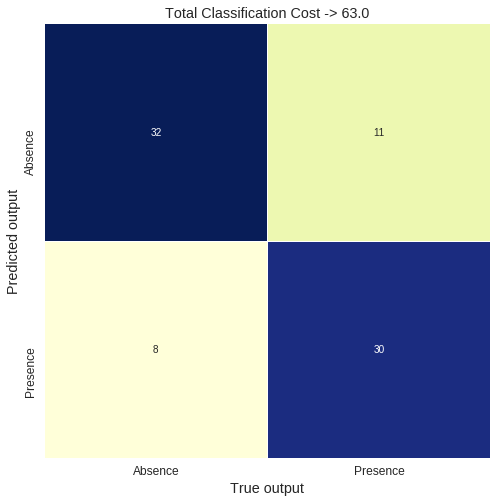


---------------------------------------------------------------

SVM: 

              precision    recall  f1-score   support

     Absence       0.83      0.79      0.81        43
    Presence       0.78      0.82      0.79        38

   micro avg       0.80      0.80      0.80        81
   macro avg       0.80      0.80      0.80        81
weighted avg       0.80      0.80      0.80        81



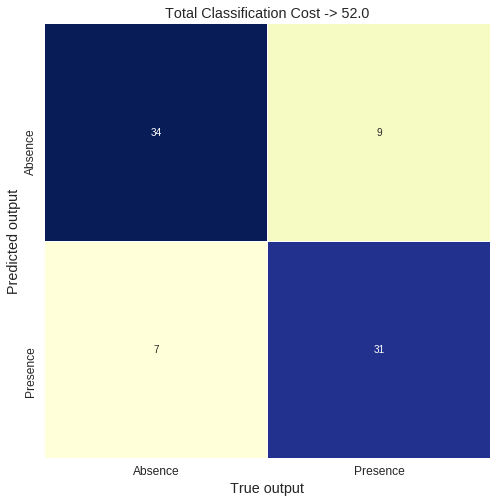


---------------------------------------------------------------

Bayes: 

              precision    recall  f1-score   support

     Absence       0.79      0.88      0.84        43
    Presence       0.85      0.74      0.79        38

   micro avg       0.81      0.81      0.81        81
   macro avg       0.82      0.81      0.81        81
weighted avg       0.82      0.81      0.81        81



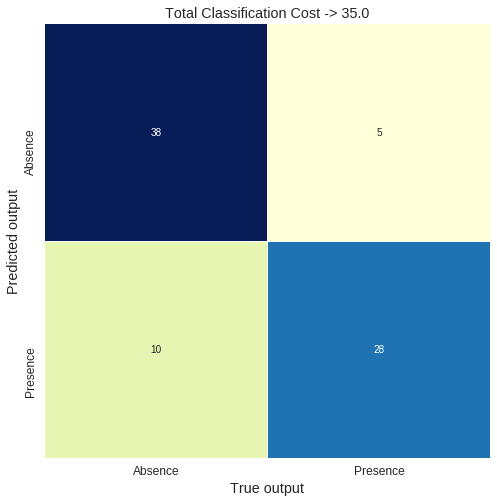

In [23]:
def simple_predict(clf):
    """
    Predicts without using any cost sensitive method, provided a given classifier.
    
    :param clf: the classifier to make prediction with.
    """
    clf.fit(X_train, y_train)
    return clf.predict(X_test)

# Make a full report for all the classifiers.
full_cs_report(y_test, 
               simple_predict(forest),
               simple_predict(svm),
               simple_predict(bayes),
               labels, cost_mat_test)

We noticed that the F1 score is good, but the classification cost is high. For that reason, we need to "tell" our model to be more careful about false positives.

# Sigmoid Probability Calibration

Random Forest: 

              precision    recall  f1-score   support

     Absence       0.57      1.00      0.72        43
    Presence       1.00      0.13      0.23        38

   micro avg       0.59      0.59      0.59        81
   macro avg       0.78      0.57      0.48        81
weighted avg       0.77      0.59      0.49        81



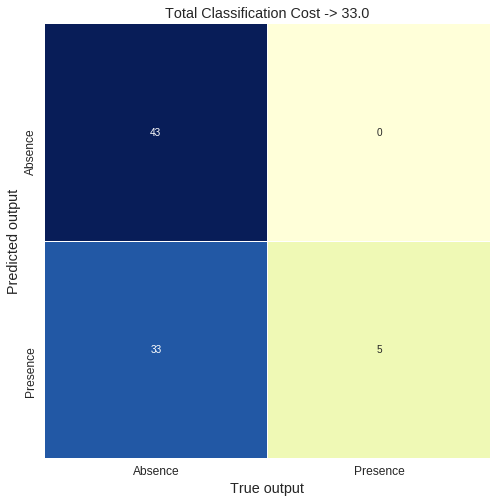


---------------------------------------------------------------

SVM: 

              precision    recall  f1-score   support

     Absence       0.67      1.00      0.80        43
    Presence       1.00      0.45      0.62        38

   micro avg       0.74      0.74      0.74        81
   macro avg       0.84      0.72      0.71        81
weighted avg       0.83      0.74      0.72        81



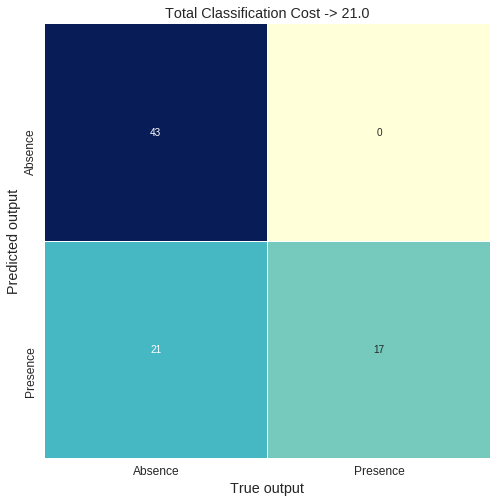


---------------------------------------------------------------

Bayes: 

              precision    recall  f1-score   support

     Absence       0.58      1.00      0.74        43
    Presence       1.00      0.18      0.31        38

   micro avg       0.62      0.62      0.62        81
   macro avg       0.79      0.59      0.52        81
weighted avg       0.78      0.62      0.54        81



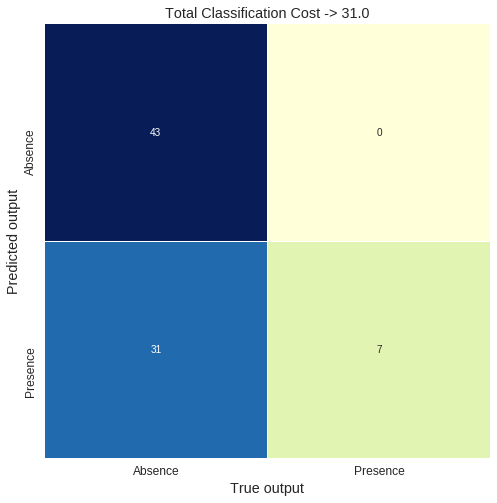

In [24]:
def calibration_predict(clf):
    """
    Predicts using sigmoid probability calibration with a given classifier.
    """
    cc = CalibratedClassifierCV(clf, method='sigmoid', cv=10)
    model = cc.fit(X_train, y_train)
    prob_test = model.predict_proba(X_test)
    bmr = BayesMinimumRiskClassifier(calibration=False)
    
    return bmr.predict(prob_test, cost_mat_test)

# Make a full report for all the classifiers.
full_cs_report(y_test, 
               calibration_predict(forest),
               calibration_predict(svm),
               calibration_predict(bayes),
               labels, cost_mat_test)

We noticed that the model chooses the class **'Presence'** more often, in order to avoid making mistakes that cost a lot.  
Moreover, the F1 score reduced, but this is not what we should try to improve. The total cost is the most important metric for this task.

# Rebalancing

Random Forest: 

              precision    recall  f1-score   support

     Absence       0.53      1.00      0.69        43
    Presence       0.00      0.00      0.00        38

   micro avg       0.53      0.53      0.53        81
   macro avg       0.27      0.50      0.35        81
weighted avg       0.28      0.53      0.37        81



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


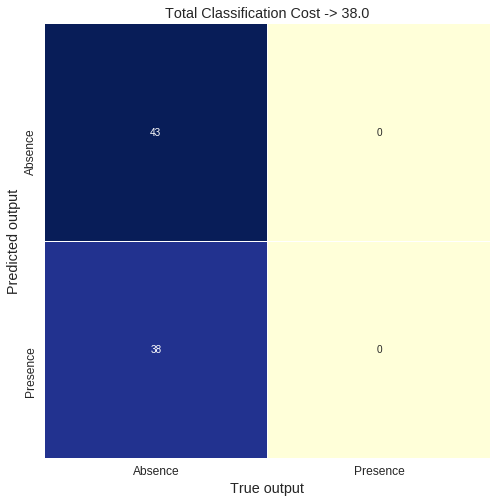


---------------------------------------------------------------

SVM: 

              precision    recall  f1-score   support

     Absence       0.72      0.95      0.82        43
    Presence       0.92      0.58      0.71        38

   micro avg       0.78      0.78      0.78        81
   macro avg       0.82      0.77      0.76        81
weighted avg       0.81      0.78      0.77        81



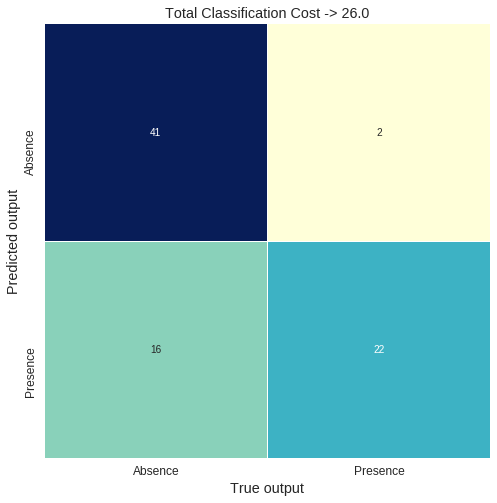


---------------------------------------------------------------

Bayes: 

              precision    recall  f1-score   support

     Absence       0.54      1.00      0.70        43
    Presence       1.00      0.03      0.05        38

   micro avg       0.54      0.54      0.54        81
   macro avg       0.77      0.51      0.38        81
weighted avg       0.75      0.54      0.40        81



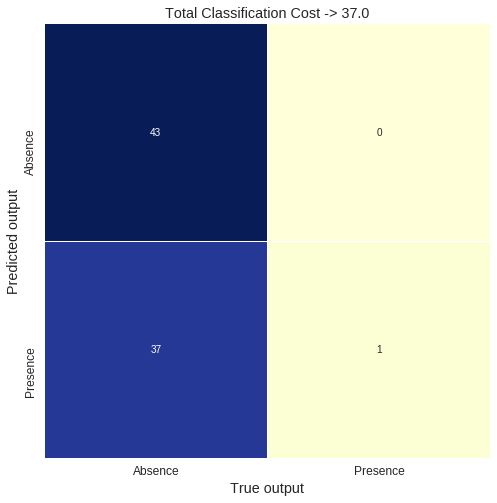

In [25]:
def roulette_sampling():
    # Set numpy seed.
    np.random.seed(0)
    
    # Define some arrays for the examples costs and the resampled X and y.
    costs = np.empty(X_train.shape[0], int)
    X_resampled = np.empty(X_train.shape)
    y_resampled = np.empty(X_train.shape[0], int)

    # Set the examples costs.
    costs[y_train == 0] = 5
    costs[y_train == 1] = 1

    # Calculate the probability of an example being chosen, 
    # based on the division of its cost with the total cost.
    total_cost = np.sum(costs)
    probs = costs/total_cost
    # Choose an index with replacement randomly, given the calculated probabilities.
    indices = np.random.choice(X_train.shape[0], X_train.shape[0], True, probs)

    # Get the X and y corresponding to the randomly chosen indices.
    for counter, index in enumerate(indices):
        X_resampled[counter, :] = X_train[index, :]
        y_resampled[counter] = y_train[index]
        
    return X_resampled, y_resampled

def rebalancing_predict(clf):
    """
    Predicts using random underampling and random oversampling with a given classifier.
    """
    # Resample data. 
    X_resampled, y_resampled = roulette_sampling()
    
    # Fit classifier with the undersampled data.
    clf.fit(X_resampled, y_resampled)
    
    # Return predictions.
    return clf.predict(X_test)

# Make a full report for all the classifiers.
full_cs_report(y_test, 
               rebalancing_predict(forest),
               rebalancing_predict(svm),
               rebalancing_predict(bayes),
               labels, cost_mat_test)

Rebalancing worked better for Random Forest, but not for the other classifiers.

# Sample Weighting

Random Forest: 

              precision    recall  f1-score   support

     Absence       0.63      0.98      0.76        43
    Presence       0.93      0.34      0.50        38

   micro avg       0.68      0.68      0.68        81
   macro avg       0.78      0.66      0.63        81
weighted avg       0.77      0.68      0.64        81



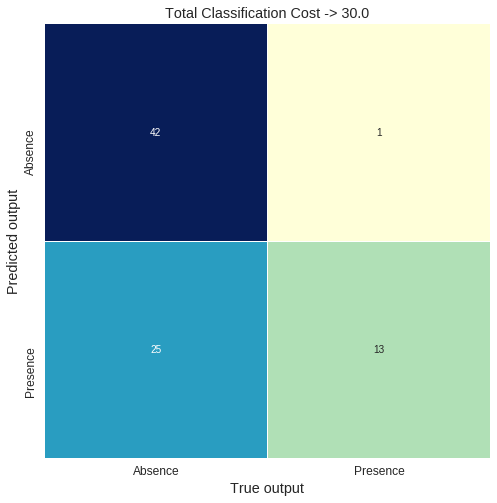


---------------------------------------------------------------

SVM: 

              precision    recall  f1-score   support

     Absence       0.83      0.79      0.81        43
    Presence       0.78      0.82      0.79        38

   micro avg       0.80      0.80      0.80        81
   macro avg       0.80      0.80      0.80        81
weighted avg       0.80      0.80      0.80        81



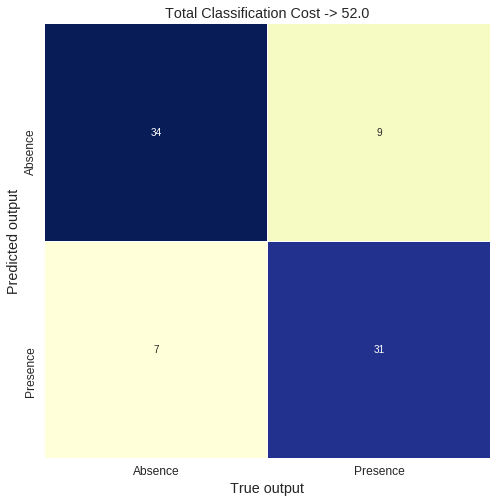


---------------------------------------------------------------

Bayes: 

              precision    recall  f1-score   support

     Absence       0.54      1.00      0.70        43
    Presence       1.00      0.05      0.10        38

   micro avg       0.56      0.56      0.56        81
   macro avg       0.77      0.53      0.40        81
weighted avg       0.76      0.56      0.42        81



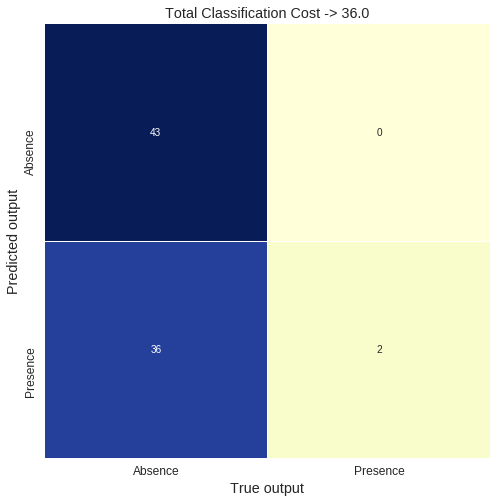

In [26]:
def weighting_predict(clf):
    """
    Predicts using sample weighting with a given classifier.
    """
    # Create the sample weights according to labels.
    weights = np.zeros(y_train.shape[0])
    weights[y_train == 0] = 5
    weights[y_train == 1] = 1

    # Fit classifier using the weights.
    clf.fit(X_train, y_train, weights)
    
    # Return predictions.
    return clf.predict(X_test)

# Make a full report for all the classifiers.
full_cs_report(y_test, 
               weighting_predict(forest),
               weighting_predict(svm),
               weighting_predict(bayes),
               labels, cost_mat_test)

Example weighting works well for Random Forest, but produces bad results for the others.

# Results
![Results](./images/PartB_Results.png)

# Conclusion

The Example Weighting method is not stable for this task because it creates big differences among the models prediction costs, thus introducing variance.  
The most important metric is the total cost, since when using the F1, precision and Recall, the importance of some types of misclassifications is not taken into consideration.